## Model Selection

This notebook should include preliminary and baseline modeling.
- Try as many different models as possible.
- Don't worry about hyperparameter tuning or cross validation here.
- Ideas include:
    - linear regression
    - support vector machines
    - random forest
    - xgboost

### Linear Regression

In [72]:
# import models and fit
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [73]:
df = pd.read_csv('data/processed/df_scaled.csv')

In [74]:
X = df.drop(columns=['sold_price'])  # features
y = df['sold_price']                # target variable
print(df.dtypes)

tags                     object
permalink                object
status                   object
list_date                object
description              object
branding                 object
lead_attributes          object
property_id               int64
photos                   object
flags                    object
community                object
virtual_tours            object
listing_id              float64
price_reduced_amount    float64
location                 object
matterport                 bool
city                     object
state                    object
Sold Price              float64
sold_price              float64
log_price               float64
dtype: object


In [75]:
print(df.iloc[0])

tags                    ['carport', 'community_outdoor_space', 'cul_de...
permalink                    9453-Herbert-Pl_Juneau_AK_99801_M90744-30767
status                                                               sold
list_date                                     2023-06-29T21:16:25.000000Z
description             {'year_built': 1963, 'baths_3qtr': None, 'sold...
branding                [{'name': 'EXP Realty LLC - Southeast Alaska',...
lead_attributes                           {'show_contact_an_agent': True}
property_id                                                    9074430767
photos                  [{'tags': [{'label': 'house_view', 'probabilit...
flags                   {'is_new_construction': None, 'is_for_rent': N...
community                                                             NaN
virtual_tours                                                           0
listing_id                                                   2957241843.0
price_reduced_amount                  

In [76]:
# tags nested in dict columns or stringified object; search all columns and extract tags
def extract_tags_from_row(row):
    for col in row.index:
        value = row[col]
        if isinstance(value, dict) and 'tags' in value:
            return value['tags']
    return None

# apply across rows
df['tags'] = df.apply(extract_tags_from_row, axis=1)

In [77]:
# handle tag lists OHE
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# drop NaNs in tags
df['tags'] = df['tags'].dropna()

# OHE encode tags
mlb = MultiLabelBinarizer()
tag_dummies = pd.DataFrame(mlb.fit_transform(df['tags'].dropna()), columns=mlb.classes_)

# reindex match df
tag_dummies.index = df['tags'].dropna().index

# merge into original DataFrame
df = pd.concat([df, tag_dummies], axis=1)

In [78]:
# prepare features and target
# X = all columns except the target
X = df.drop(columns=['Sold Price'])

# y = target column
y = df['Sold Price']

In [79]:
print(X.select_dtypes(include=['object']).columns)

Index(['tags', 'permalink', 'status', 'list_date', 'description', 'branding',
       'lead_attributes', 'photos', 'flags', 'community', 'virtual_tours',
       'location', 'city', 'state'],
      dtype='object')


In [80]:
X = X.drop(columns=['tags', 'permalink', 'status', 'list_date', 'description', 'branding',
       'lead_attributes', 'photos', 'flags', 'community', 'virtual_tours',
       'location', 'city', 'state'])

In [81]:
print(X.isna().sum())

property_id                0
listing_id               407
price_reduced_amount       0
matterport                 0
sold_price              1443
log_price               1443
dtype: int64


In [82]:
# Drop 'log_price' from features
X = X.drop(columns=['log_price'])

# Drop rows where the target (y) is missing
not_nan_mask = y.notna()
X = X.loc[not_nan_mask]
y = y.loc[not_nan_mask]

# Fill missing values in X using the mean (after y cleaning)
X = X.fillna(X.mean())

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Use the cleaned y without NaNs 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit model
model = LinearRegression()
model.fit(X_train, y_train)
print(model)

LinearRegression()


In [84]:
#evaluate model 
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {mse**0.5:.2f}")
print(f"R² Score (Coefficient of Determination): {r2:.2f}")

Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
R² Score (Coefficient of Determination): 1.00


In [85]:
not_nan_mask = y.notna()
X = X.loc[not_nan_mask]
y = y.loc[not_nan_mask]

print(regressor.coef_) #NumPy array with beta coefficients

NameError: name 'regressor' is not defined

In [86]:
#feature importance (coefficients); positive coefficients increase the predicted price; negative coefficients decrease it; understand drivers of price.
import pandas as pd

coefficients = pd.Series(model.coef_, index=X.columns)
coefficients = coefficients.sort_values(ascending=False)

print("Top positive features:")
print(coefficients.head(10))

print("\nTop negative features:")
print(coefficients.tail(10))

Top positive features:
sold_price              1.000000e+00
price_reduced_amount    5.050700e-17
property_id             3.206545e-26
listing_id             -1.985233e-23
matterport             -4.838667e-16
dtype: float64

Top negative features:
sold_price              1.000000e+00
price_reduced_amount    5.050700e-17
property_id             3.206545e-26
listing_id             -1.985233e-23
matterport             -4.838667e-16
dtype: float64


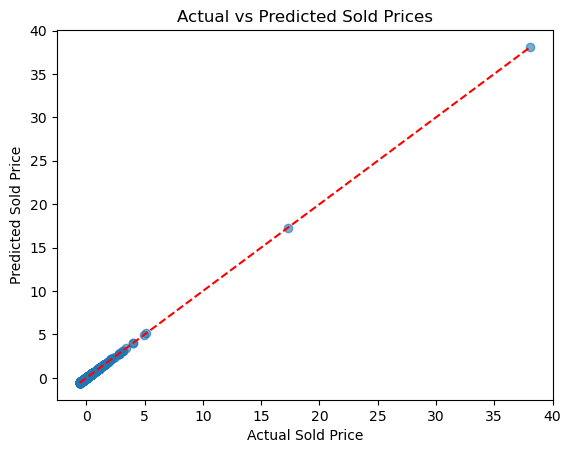

In [87]:
#visualize results Actrual vs Predicated prices 
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sold Price")
plt.ylabel("Predicted Sold Price")
plt.title("Actual vs Predicted Sold Prices")
plt.show()

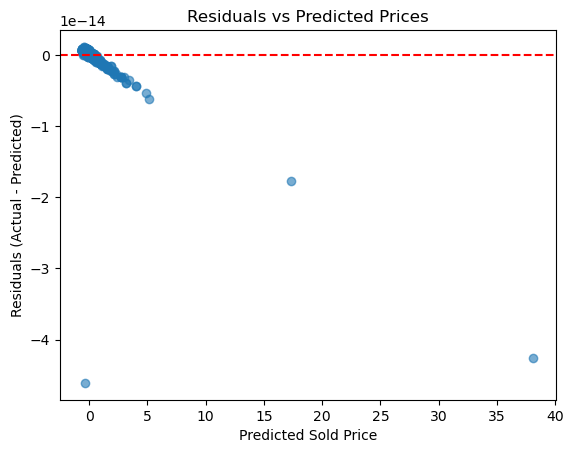

In [88]:
# visualize Residual Plot
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sold Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Prices")
plt.show()

Consider what metrics you want to use to evaluate success.
- If you think about mean squared error, can we actually relate to the amount of error?
- Try root mean squared error so that error is closer to the original units (dollars)
- What does RMSE do to outliers?
- Is mean absolute error a good metric for this problem?
- What about R^2? Adjusted R^2?
- Briefly describe your reasons for picking the metrics you use

In [89]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Train on the training data
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Results:")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {mse_rf**0.5:.2f}")
print(f"R² Score: {r2_rf:.2f}")

Random Forest Regressor Results:
Mean Squared Error (MSE): 0.07
Root Mean Squared Error (RMSE): 0.27
R² Score: 0.95


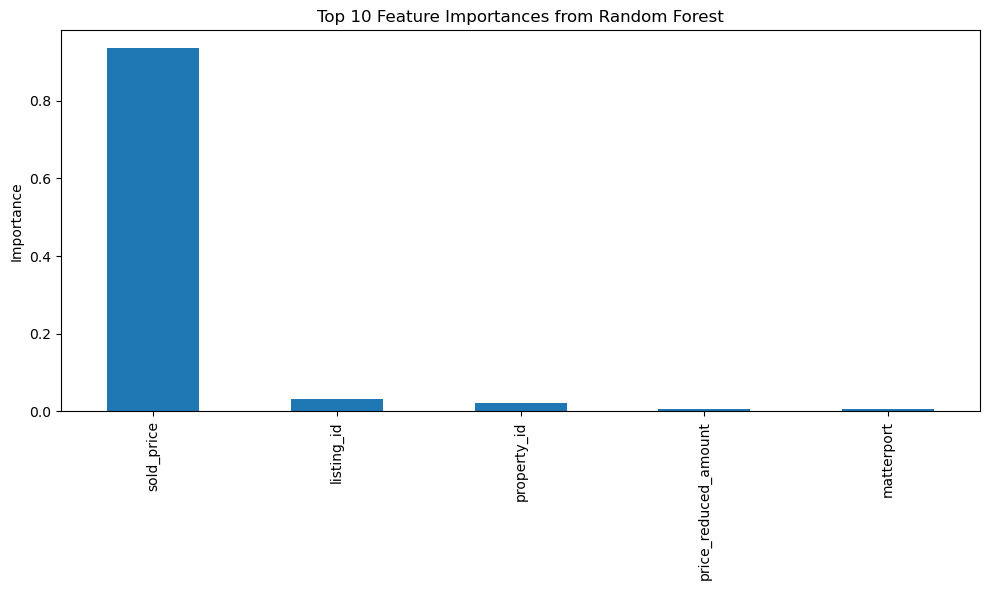

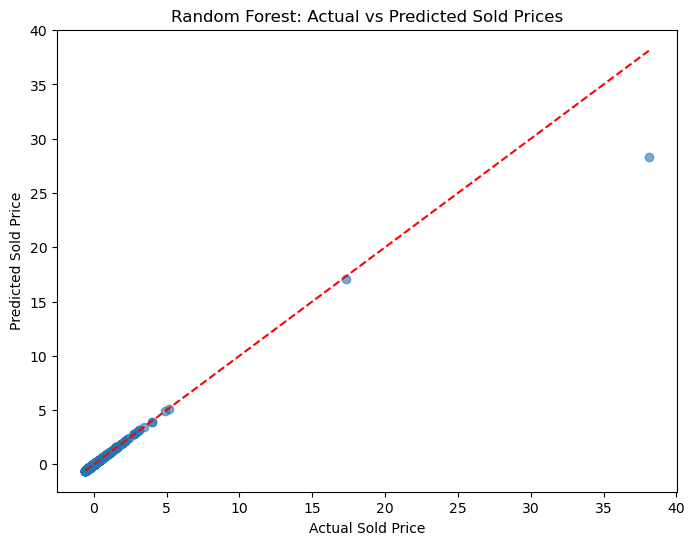

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature importances as a Series sorted descending
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 10 feature importances
plt.figure(figsize=(10,6))
importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted for Random Forest
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sold Price')
plt.ylabel('Predicted Sold Price')
plt.title('Random Forest: Actual vs Predicted Sold Prices')
plt.show()

In [91]:
#XGBoost

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the regressor
xgb_model = xgb.XGBRegressor(random_state=42, verbosity=0)

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor Results:")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {mse_xgb**0.5:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

XGBoost Regressor Results:
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
R² Score: 1.00


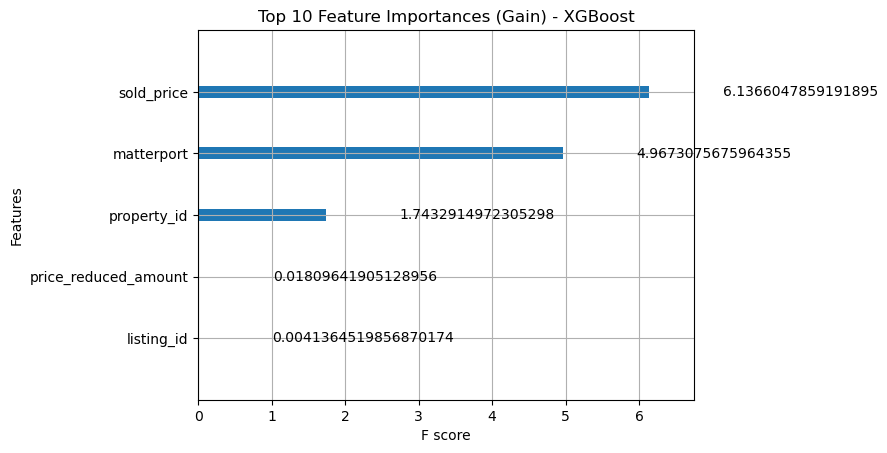

In [92]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title('Top 10 Feature Importances (Gain) - XGBoost')
plt.show()

## Feature Selection - STRETCH

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its recommended you complete it if you have time!**

Even with all the preprocessing we did in Notebook 1, you probably still have a lot of features. Are they all important for prediction?

Investigate some feature selection algorithms (Lasso, RFE, Forward/Backward Selection)
- Perform feature selection to get a reduced subset of your original features
- Refit your models with this reduced dimensionality - how does performance change on your chosen metrics?
- Based on this, should you include feature selection in your final pipeline? Explain

Remember, feature selection often doesn't directly improve performance, but if performance remains the same, a simpler model is often preferrable. 



In [ ]:
# perform feature selection 
# refit models
# gather evaluation metrics and compare to the previous step (full feature set)